In [1]:
# Import libraries
import awswrangler as wr
import numpy as np
import pandas as pd

from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np
from sklearn.metrics import mean_absolute_error
print(tf.__version__)


2.7.0


In [2]:
dataset = 'feature_extract'

In [3]:
# Read in train dataset
train = pd.read_csv('Endometriosis_subset_train_feature_extract_no_mamc_splitfunction.csv')

# Set axis to IDs
train.set_axis(train['meth_id'], inplace = True)

# Drop the ID cols 
cols_drop = ['meth_id', 'meth_id.1']
train.drop(columns=cols_drop, inplace = True)

# Change Endo Yes/No to binary
train['Cycle_Phase_1'] = np.where(train['Cycle_Phase'] == 'PE', 0, '')
train['Cycle_Phase_2'] = np.where(train['Cycle_Phase'] == 'SE', 1, '')
train['Cycle_Phase_3'] = np.where(train['Cycle_Phase'] == 'Menstrual', 2, '')
train['Cycle_Phase_int'] = train['Cycle_Phase_1'] + train['Cycle_Phase_2'] + train['Cycle_Phase_3'] 

# Drop Menstrual phase
train.drop(train[train['Cycle_Phase_int'] == '2'].index, inplace = True)

# Split features and labels
y_train = train['Cycle_Phase_int']
x_train = train.iloc[:, 5:-5]

In [4]:
# read val dataset
val = pd.read_csv('Endometriosis_subset_val_feature_extract_no_mamc_splitfunction.csv')
val = val.set_axis(val['meth_id'])

# Group ESE, MSE and LSE into SE 
val.loc[val['Cycle_Phase'].isin(['ESE', 'MSE', 'LSE']), 'Cycle_Phase'] = 'SE'

# Change Endo Yes/No to binary
val['Cycle_Phase_1'] = np.where(val['Cycle_Phase'] == 'PE', 0, '')
val['Cycle_Phase_2'] = np.where(val['Cycle_Phase'] == 'SE', 1, '')
val['Cycle_Phase_3'] = np.where(val['Cycle_Phase'] == 'Menstrual', 2, '')
val['Cycle_Phase_int'] = val['Cycle_Phase_1'] + val['Cycle_Phase_2'] + val['Cycle_Phase_3'] 

# Drop Menstrual phase
val.drop(val[val['Cycle_Phase_int'] == '2'].index, inplace = True)

# Split features and labels
y_val = val['Cycle_Phase_int']
x_val = val.iloc[:, 6:-5]

In [5]:
# read external test set
test2 = pd.read_csv('Endometriosis_subset_test2_feature_extract_no_mamc_splitfunction.csv')

test2.set_index('meth_id', inplace = True)

# Group ESE, MSE and LSE into SE 
test2.loc[test2['Cycle_Phase'].isin(['ESE', 'MSE', 'LSE']), 'Cycle_Phase'] = 'SE'

# Change Endo Yes/No to binary
test2['Cycle_Phase_1'] = np.where(test2['Cycle_Phase'] == 'PE', 0, '')
test2['Cycle_Phase_2'] = np.where(test2['Cycle_Phase'] == 'SE', 1, '')
test2['Cycle_Phase_3'] = np.where(test2['Cycle_Phase'] == 'Menstrual', 2, '')
test2['Cycle_Phase_int'] = test2['Cycle_Phase_1'] + test2['Cycle_Phase_2'] + test2['Cycle_Phase_3'] 

# Drop Menstrual phase
test2.drop(test2[test2['Cycle_Phase_int'] == '2'].index, inplace = True)

# Split features and labels
y_test2 = test2['Cycle_Phase_int']
x_test2 = test2.iloc[:, 6:-4]

In [6]:
x_train_df = x_train
x_val_df = x_val

In [7]:
feature_names = x_train.columns

In [8]:
import pandas as pd 
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.metrics import r2_score
import itertools 
from itertools import chain
from sklearn.model_selection import train_test_split
import scipy 
from scipy.stats import linregress

# Assign parameters
activation1 = 'relu'
activation2 = 'exponential'
nodes = 500

    
# Convert to float32
x_train = np.asarray(x_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
x_val = np.asarray(x_val).astype('float32')
y_val = np.asarray(y_val).astype('float32')
x_test2 = np.asarray(x_test2).astype('float32')
y_test2 = np.asarray(y_test2).astype('float32')


# build model
model = Sequential()
model.add(Dense(nodes, input_dim=x_train.shape[1], activation = activation1))
model.add(Dense(nodes, activation= activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation1))
model.add(Dense(nodes, activation=activation2))
model.add(Dense(1))
model.compile(loss='mae', optimizer=tf.optimizers.Adamax(0.00001), metrics=['mae'])

class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0: print('')
            print('.', end='')

# Training
history = model.fit(x_train,y_train, validation_data=(x_val,y_val),verbose=0,
      epochs=500, callbacks = [PrintDot()])

train_pred = model.predict(x_train)

# Test Prediction
pred = model.predict(x_val)

# External Test Prediction
pred_ext = model.predict(x_test2)


# Measure this fold's MAE
train_score = np.sqrt(metrics.mean_absolute_error(train_pred, y_train))
#R2_train = r2_score(train_pred, y_train)
r_val = np.corrcoef(train_pred.flatten(), y_train.flatten())
R2_train = str(r_val[0, 1]**2)
print(f"Train score (R2): {R2_train}")
print(f"Train score (MAE): {train_score}")


score_val = np.sqrt(metrics.mean_absolute_error(pred,y_val))
#R2 = r2_score(pred, y_val)
r_val = np.corrcoef(pred.flatten(), y_val.flatten())
R2_val = str(r_val[0, 1]**2)
print(f"Test score (R2): {R2_val}")
print(f"Test score (MAE): {score_val}")
    
    
score_ext = np.sqrt(metrics.mean_absolute_error(pred_ext,y_test2))
#R2 = r2_score(pred, y_val)
r_val = np.corrcoef(pred_ext.flatten(), y_test2.flatten())
R2_ext = str(r_val[0, 1]**2)
print(f"External Test score (R2): {R2_ext}")
print(f"External Test score (MAE): {score_ext}")


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................Train score (R2): 0.9999096823830479
Train score (MAE): 0.06466245651245117
Test score (R2): 0.6074809643371021
Test score (MAE): 0.44760340452194214
External Test score (R2): 0.752414878161217
External Test score (MAE): 0.32724615931510925


In [9]:
score = np.sqrt(metrics.mean_absolute_error(pred_ext,y_test2))

In [10]:
train_pred = train_pred.flatten()

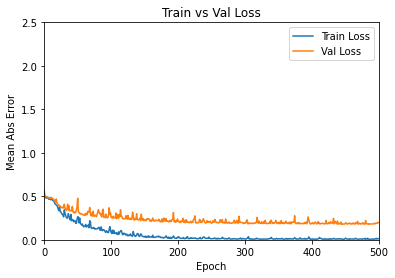

In [11]:
# plot train vs val loss 
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.subplot()
ax.plot(history.epoch, np.array(history.history['mae']),
           label='Train Loss')
ax.plot(history.epoch, np.array(history.history['val_mae']),
           label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.title('Train vs Val Loss')
plt.legend()
plt.ylim([0, 2.5])
plt.xlim([0, 500])
plt.show()
fig.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'train_loss_Cycle_Phase.png', dpi=400, bbox_inches = "tight")

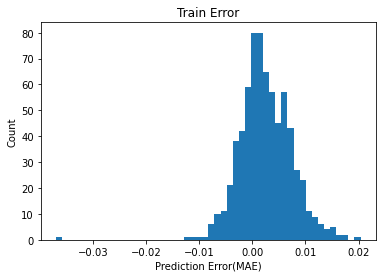

In [12]:
# plot train error distribution
error = train_pred - y_train
plt.hist(error, bins = 50)
plt.title('Train Error')
plt.xlabel("Prediction Error(MAE)")
_ = plt.ylabel("Count")
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'train_error_Cycle_Phase.png', bbox_inches = "tight")

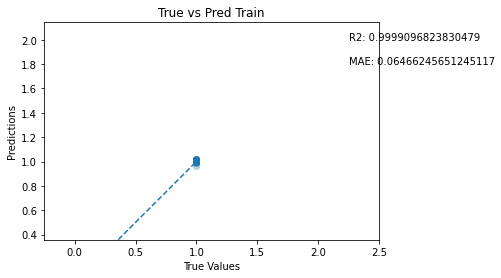

In [13]:
# plot true vs pred for train dataset
plt.scatter(y_train, train_pred, alpha = 0.3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.title('True vs Pred Train')
plt.text(2.25, 2, f"R2: {R2_train}")
plt.text(2.25, 1.8, f"MAE: {train_score}")
plt.xlim(-0.25, 2.5)
plt.ylim(0, 2.5)
plt.plot([0, 1], [0,1], '--')
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'true_vs_pred_train_Cycle_Phase.png', bbox_inches = "tight")

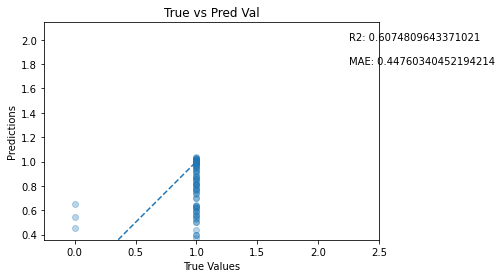

In [14]:
# plot true vs pred for val set
plt.scatter(y_val, pred, alpha = 0.3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.title('True vs Pred Val')
plt.text(2.25, 2, f"R2: {R2_val}")
plt.text(2.25, 1.8, f"MAE: {score_val}")
plt.xlim(-0.25, 2.5)
plt.ylim(0, 2.5)
plt.plot([0, 1], [0,1], '--')
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'true_vs_pred_val_Cycle_Phase.png', bbox_inches = "tight")

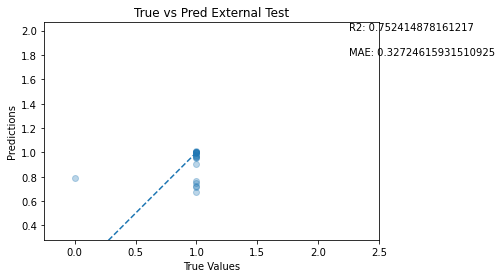

In [15]:
# plot true vs pred for ext test set
plt.scatter(y_test2.flatten(), pred_ext.flatten(), alpha = 0.3)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.title('True vs Pred External Test')
plt.text(2.25, 2, f"R2: {R2_ext}")
plt.text(2.25, 1.8, f"MAE: {score_ext}")
plt.xlim(-0.25, 2.5)
plt.ylim(-0.4, 2.75)
plt.plot([0, 1], [0,1], '--')
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'true_vs_pred_external_test_Cycle_Phase.png', bbox_inches = "tight")

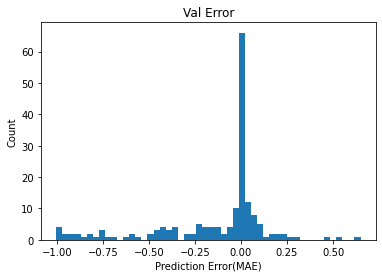

In [16]:
# plot ext val error distribution
error = pred.flatten() - y_val.flatten()
plt.hist(error, bins = 50)
plt.title('Val Error')
plt.xlabel("Prediction Error(MAE)")
_ = plt.ylabel("Count")
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'val_error_Cycle_Phase.png', bbox_inches = "tight")

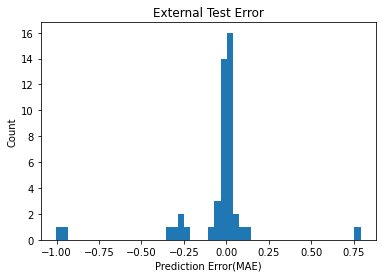

In [17]:
# plot ext test error distribution
error = pred_ext.flatten() - y_test2.flatten()
plt.hist(error, bins = 50)
plt.title('External Test Error')
plt.xlabel("Prediction Error(MAE)")
_ = plt.ylabel("Count")
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'external_test_error_Cycle_Phase.png', bbox_inches = "tight")

In [18]:
# make predictions binary
test_pred_int = np.where(pred<0.5, 0, 1)
train_pred_int = np.where(train_pred<0.5, 0, 1)
ext_test_pred_int = np.where(pred_ext<0.5, 0, 1)

In [19]:
# make confusion matrices
from sklearn.metrics import confusion_matrix
test_conf = confusion_matrix(y_val, test_pred_int)
train_conf = confusion_matrix(y_train, train_pred_int)
ext_test_conf = confusion_matrix(y_test2, ext_test_pred_int)

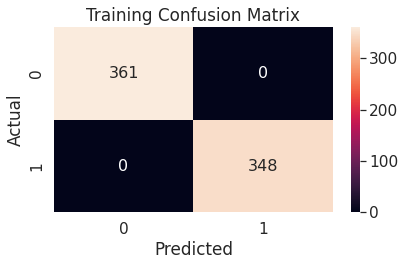

In [20]:
import seaborn as sns
df_cm = pd.DataFrame(train_conf, range(2), range(2))
#df_cm = df_cm.rename(index={0: "PE", 1: "Case"})
#df_cm = df_cm.rename(columns={0: "Control", 1: "Case"})
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Training Confusion Matrix')
plt.tight_layout()
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'confusion_matrix_train_Cycle_Phase.png', bbox_inches = "tight")

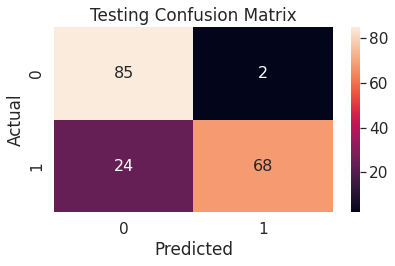

In [21]:
import seaborn as sns
df_cm = pd.DataFrame(test_conf, range(2), range(2))
#df_cm = df_cm.rename(index={0: "Control", 1: "Case"})
#df_cm = df_cm.rename(columns={0: "Control", 1: "Case"})
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Testing Confusion Matrix')
plt.tight_layout()
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'confusion_matrix_val_Cycle_Phase.png', bbox_inches = "tight")

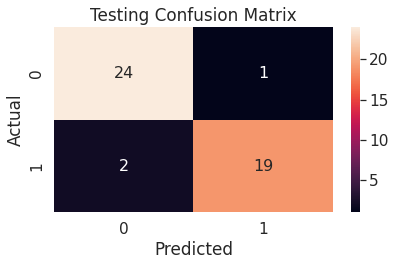

In [22]:
df_cm = pd.DataFrame(ext_test_conf, range(2), range(2))
#df_cm = df_cm.rename(index={0: "Control", 1: "Case"})
#df_cm = df_cm.rename(columns={0: "Control", 1: "Case"})
# plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Testing Confusion Matrix')
plt.tight_layout()
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'confusion_matrix_external_test_Cycle_Phase.png', bbox_inches = "tight")

In [23]:
r_probs = [0 for _ in range(len(y_val))]

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
#Random chance ROC
r_auc = roc_auc_score(y_val, r_probs)
r_fpr, r_tpr, _ = roc_curve(y_val, r_probs)

#Val ROC
fpr, tpr, _ = roc_curve(y_val, pred)
auc = roc_auc_score(y_val, pred)


#Train ROC
tr_fpr, tr_tpr, _ = roc_curve(y_train, train_pred)
tr_auc = roc_auc_score(y_train, train_pred)

# External Test ROC
ext_fpr, ext_tpr, _ = roc_curve(y_test2, pred_ext)
ext_auc = roc_auc_score(y_test2, pred_ext)

In [25]:
print('Random (chance) Prediction: AUROC = %.3f' % (r_auc))
print('Test Prediction: AUROC = %.3f' % (auc))
print('Train Prediction: AUROC = %.3f' % (tr_auc))
print('External Test Prediction: AUROC = %.3f' % (ext_auc))

Random (chance) Prediction: AUROC = 0.500
Test Prediction: AUROC = 0.944
Train Prediction: AUROC = 1.000
External Test Prediction: AUROC = 0.941


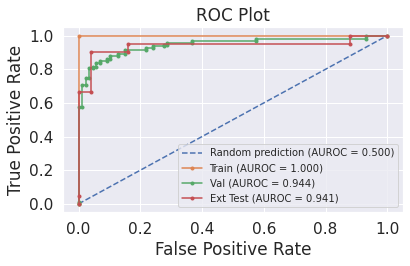

In [26]:
# plot ROC plot
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(tr_fpr, tr_tpr, marker='.', label='Train (AUROC = %0.3f)' % tr_auc)
plt.plot(fpr, tpr, marker='.', label='Val (AUROC = %0.3f)' % auc)
plt.plot(ext_fpr, ext_tpr, marker='.', label='Ext Test (AUROC = %0.3f)' % ext_auc)

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend(loc = 'lower right', prop={'size': 10}) 
plt.tight_layout()
plt.savefig(dataset + '_' + activation1 + '_' + activation2 + '_' + 'ROC_Curve.png', bbox_inches = "tight")